In [71]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
import json
import imageio
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn.mixture import BayesianGaussianMixture
from sklearn.model_selection import StratifiedKFold

%run ../Scripts/analysis.py
foldername = "test1/"

In [38]:
with open(foldername + "params.json") as json_file:
    params = json.load(json_file)
with open(foldername + "sim_params.json") as json_file:
    sim_params = json.load(json_file)

In [101]:
i = 700
n_i = scipy.sparse.load_npz(foldername+f"sp_frame_n{i}.npz").todok()
nh_i = scipy.sparse.load_npz(foldername+f"sp_frame_nh{i}.npz").todok()

In [102]:
x_ind, y_ind = np.nonzero(n_i)
nonzero_values = [n_i[index] for index in zip(x_ind, y_ind)]
index_nonzero_w_repeats = []
for value, index in zip(nonzero_values, zip(x_ind, y_ind)):
    for i in range(int(value)):
        index_nonzero_w_repeats.append(index)

In [93]:
def make_ellipse(means, covariances, color = "navy"):
    v, w = np.linalg.eigh(covariances)
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan2(u[1], u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    ell = mpl.patches.Ellipse(
        means, v[0], v[1], 180 + angle, color=color
    )
    return ell

In [161]:
random_state, n_components, n_features = 2, 10, 2

gaussian_estimator =  BayesianGaussianMixture(
            weight_concentration_prior_type="dirichlet_distribution",
            n_components= 2*n_components,
            reg_covar=0,
            init_params="random",
            max_iter=1500,
            mean_precision_prior=0.8,
            random_state=random_state,
            weight_concentration_prior = 10000
        )
gaussian_estimator.fit(index_nonzero_w_repeats)

covariances = gaussian_estimator.covariances_
means = gaussian_estimator.means_
clusters = gaussian_estimator.predict(index_nonzero_w_repeats)
len(np.unique(clusters))

17

In [172]:
means_red = []
covs_red = []
for i in range(len(np.unique(clusters))):
    means_red.append(means[i])
    covs_red.append(covariances[i])

_ , counts = np.unique(clusters, return_counts= True)


/var/folders/9_/htwk2tpd6tv_fy1sp81nfcsm0000gn/T/ipykernel_40426/3005710689.py:7: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ell = mpl.patches.Ellipse(


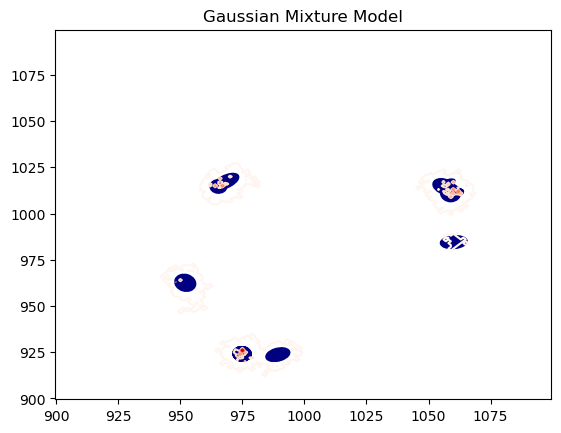

In [173]:
fig, ax = plt.subplots()
plt.title("Gaussian Mixture Model")
ax.contour(n_i.toarray().transpose(), cmap = "Reds") #Note that contour is trasnposed
ax.margins(-0.45, -0.45)
for mean1 , cov1 in zip(means_red, covs_red):
    ell1 = make_ellipse(mean1, cov1, "navy")
    ax.add_patch(ell1)

In [179]:
means_spred = [means[0]]
covs_spred  = [covariances[0]]
i = 0

for mean , cov in zip(means_red, covs_red):
    mean_curr = means[i]
    cov_curr = covariances[i]
    diff = mean-mean_curr

    conf_region = np.matmul( diff.transpose(), np.matmul(cov_curr, diff))
    if conf_region < 9:
        covs_spred.pop()
        covs_spred.append(cov + cov_curr)
        continue

    conf_region = np.matmul( diff.transpose(), np.matmul(cov, diff))
    if conf_region < 9:
        means_spred.pop()
        means_spred.append(mean)
        covs_spred.pop()
        covs_spred.append(cov + cov_curr)
        continue

    means_spred.append(mean)
    covs_spred.append(cov)
    i += 1



/var/folders/9_/htwk2tpd6tv_fy1sp81nfcsm0000gn/T/ipykernel_40426/3005710689.py:7: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ell = mpl.patches.Ellipse(


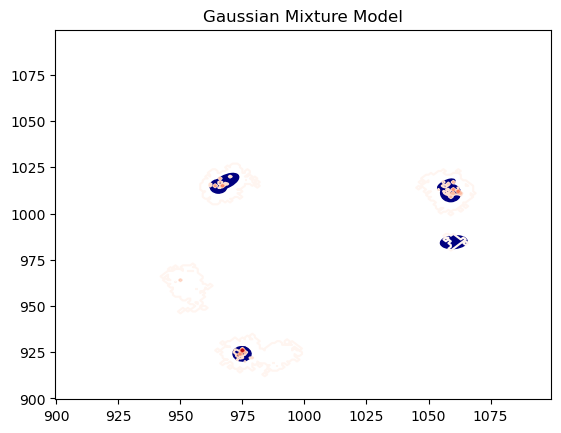

In [184]:
fig, ax = plt.subplots()
plt.title("Gaussian Mixture Model")
ax.contour(n_i.toarray().transpose(), cmap = "Reds") #Note that contour is trasnposed
ax.margins(-0.45, -0.45)
for mean1 , cov1 in zip(means_spred[:7], covs_spred[:7]):
    ell1 = make_ellipse(mean1, cov1, "navy")
    ax.add_patch(ell1)